# Setup

In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2


In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [3]:
restore_model=False
train_model=True

In [4]:
import sys 
import os 
import pathlib
# get the directory of the current notebook
fdir = pathlib.Path().parent.resolve()
# this file is located at /home/aure/Documents/GitHub/GenSBI/examples/sbi-benchmarks/two_moons/two_moons_jflux.ipynb, the root directory is GenSBI, how do I get there?
root = fdir.parent.parent.parent
sys.path.append(f"{root}/examples/sbi-benchmarks")
sys.path.append(f"{root}/src")

In [5]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = f"{root}/examples/sbi-benchmarks/two_moons"
checkpoint_dir = f"{notebook_path}/checkpoints/two_moons_simformer_diffusion"

os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
import optax
from optax.contrib import reduce_on_plateau

import grain.python as grain

from numpyro import distributions as dist

from corner import corner

import numpy as np

from tqdm.auto import tqdm

from functools import partial


/home/aure/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
# max LR
MAX_LR = 1e-3  # @param{type:"number"}
# Min scale for the learning rate:
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR  # @param{type:"number"}

In [8]:
from sbi_utils.sbi_tasks import TwoMoons
from diffusion.path import EDMPath
from diffusion.path.scheduler import EDMScheduler
from diffusion.solver import SDESolver

define the task

In [9]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()

In [10]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

In [11]:
reference_samples = task.get_reference_posterior_samples(num_observation=8)

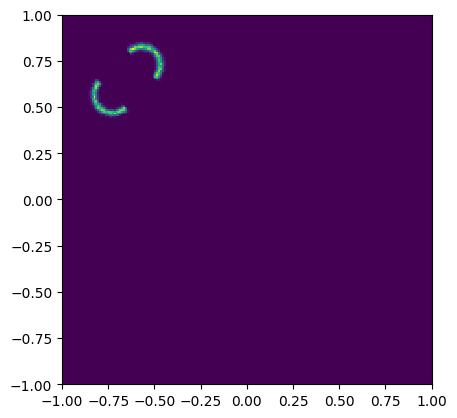

In [12]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# dataset

In [13]:
# make a dataset
nsamples = int(1e5)
val_size = 512
theta = prior.sample((nsamples+val_size,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)


train_data = data[:nsamples]
val_data = data[nsamples:]


In [14]:
batch_size = 4*1024 # the model greatly benefits from larger batch sizes to avoid overfitting, but this is limited by the GPU memor

In [15]:
dataset_grain = (
    grain.MapDataset.source(np.array(train_data))
    .shuffle(42)
    .to_iter_dataset(grain.ReadOptions(num_threads=16, prefetch_buffer_size=batch_size*5))
    .batch(batch_size=batch_size)  # Batches consecutive elements.
)

In [16]:
dataset_iter = iter(dataset_grain)

# Define the path

In [17]:
from models import Simformer, SimformerParams, SimformerConditioner
path = EDMPath(scheduler=EDMScheduler()) # define the probability path

# utils

In [ ]:
from utils.model_wrapping import ModelWrapper, GuidedModelWrapper
class SimWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def _call_model(self, x, t, args, **kwargs):
        return self.model(obs=x, timesteps=t, **kwargs)

class GuidedSimWrapper(GuidedModelWrapper):
    def __init__(self, model, cfg_scale):
        super().__init__(model, cfg_scale)

    def _call_model(self, x, t, args, **kwargs):
        return self.model(obs=x, timesteps=t, **kwargs)
    
obs_ids = jnp.array([0, 1])
cond_ids = jnp.array([2, 3])
nsteps = 30

# conditional sampling
def get_samples(score_wrapped, idx, nsamples=10_000, edge_mask=None):
    observation =  jnp.array(twomoons.get_observation(idx))
    true_param = jnp.array(task.get_true_parameters(idx))
    reference_samples = task.get_reference_posterior_samples(num_observation=idx)

    rng = jax.random.PRNGKey(45)

    key1,key2 = jax.random.split(rng, 2)


    cond = jnp.broadcast_to(observation[...,None], (1, dim_x, 1)) # n, dim_theta, 1

    solver = SDESolver(score_model=score_wrapped, path=path)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids, "edge_mask": edge_mask}

    x_init = path.sample_prior(key1, (nsamples,2) )  # sample initial points from the prior distribution
    samples = solver.sample(key2, x_init, nsteps=nsteps, model_extras=model_extras)

    return samples, true_param, reference_samples

def plot_samples(samples, true_param):
    plt.hist2d(samples[:,0], samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
    # same ratio on axis 
    plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.show()

# define the CFM model

In [19]:
from models import Simformer, SimformerParams, SimformerConditioner

In [20]:
loss_fn_diff = path.get_loss_fn() #loss_fn(F, batch, loss_mask=None, *args, **kwargs)

In [21]:
dim_joint = len(twomoons.get_node_id())

In [22]:
params = SimformerParams(
    rngs = nnx.Rngs(0),
    dim_value = 40,
    dim_id = 40, 
    dim_condition = 12, 
    dim_joint= dim_joint,
    fourier_features = 128,
    num_heads = 4,
    num_layers = 6,
    widening_factor = 3,
    qkv_features = 40, # this bottlenecks the transformer features to 40, instead of the token dimension
    num_hidden_layers = 1,
    dropout_rate = 0.0)

In [23]:
def marginalize(rng: jax.random.PRNGKey, edge_mask: jax.Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

In [24]:
undirected_edge_mask = twomoons.get_edge_mask_fn("undirected")(node_ids, None)
posterior_faithfull = twomoons.get_edge_mask_fn("faithfull")(node_ids, condition_mask=jnp.array([0,0,1,1]))

In [25]:
@partial(jax.jit, static_argnames=["nsamples"])
def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
    mask_joint = jnp.zeros((5*nsamples, dim_joint ), dtype=jnp.bool_)
    mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    # mask_likelihood = jnp.concatenate([jnp.ones((nsamples, dim_theta), dtype=jnp.bool_), jnp.zeros((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    
    mask1 = jax.random.bernoulli(rng, p=0.3, shape=(nsamples, dim_joint))
    filter = ~jnp.all(mask1, axis=-1)
    mask1 = jnp.logical_and(mask1, filter.reshape(-1,1))

    # masks = jnp.concatenate([mask_joint, mask1, mask_posterior, mask_likelihood], axis=0)
    masks = jnp.concatenate([mask_joint, mask1, mask_posterior], axis=0)
    return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)
    

In [26]:
def loss_fn_(F_model, x_1, key: jax.random.PRNGKey):

    batch_size = x_1.shape[0]

    rng_path, rng_sigma, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 5)
    
    # Generate data and random times
    sigma = path.sample_sigma(rng_sigma, x_1.shape[0])  # sample noise levels
    path_sample = path.sample(rng_path, x_1, sigma)
    batch = path_sample.get_batch()
    
    # Condition mask -> randomly condition on some data. Here you can choose between the different condition masks, and you should specify the conditionals you may want to compute afterwards.
    condition_mask = get_random_condition_mask(rng_condition, batch_size)

    # undirected_edge_mask 
    undirected_edge_mask_ = jnp.repeat(undirected_edge_mask[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # faithfull posterior mask
    faithfull_edge_mask_ = jnp.repeat(posterior_faithfull[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size,)), undirected_edge_mask)
    edge_masks = jnp.concatenate([undirected_edge_mask_, faithfull_edge_mask_, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask

    model_extras = {
        "edge_mask": edge_masks,
        "condition_mask": condition_mask,
        "node_ids": node_ids,
    }

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = loss_fn_diff(F_model, batch, loss_mask=condition_mask, model_extras=model_extras) 

    return loss

In [27]:
@nnx.jit
def train_loss(F_model, key: jax.random.PRNGKey):
    x_1 = next(dataset_iter) # n, T_max, 1
    return loss_fn_(F_model, x_1, key)

In [28]:
@nnx.jit
def val_loss(F_model, key):
    x_1 = val_data
    return loss_fn_(F_model, x_1, key)

In [29]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads, value=loss)  # In place updates.
    return loss

In [30]:
F_model = Simformer(params)

In [31]:
# restore the model
if restore_model:
    model_state = nnx.state(F_model)
    graphdef, abstract_state = nnx.split(F_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            1,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    F_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

In [32]:
# # linear learning rate schedule
# nsteps = 10_000 
# nepochs = 5


# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, 40000, 10000)

# opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

# # opt = optax.MultiSteps(opt, 2)

# optimizer = nnx.Optimizer(F_model, opt)

In [33]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 3

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(F_model, opt)

In [34]:
rngs = nnx.Rngs(0)

In [35]:
best_state = nnx.state(F_model)
best_val_loss_value = val_loss(F_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

early_stopping = True

2025-06-18 17:43:35.989191: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-18 17:43:35.989234: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-18 17:43:35.989259: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


  0%|          | 0/10000 [00:00<?, ?it/s]2025-06-18 17:43:44.626010: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-18 17:43:44.626079: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-18 17:43:44.626216: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-18 17:43:44.

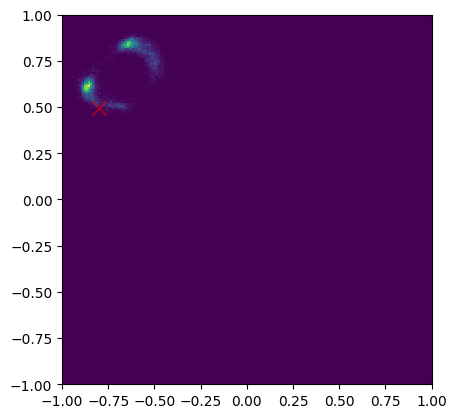

 60%|█████▉    | 5997/10000 [05:36<01:42, 39.01it/s, counter=0, loss=1.6337, ratio=0.9991, val_loss=1.6322]   

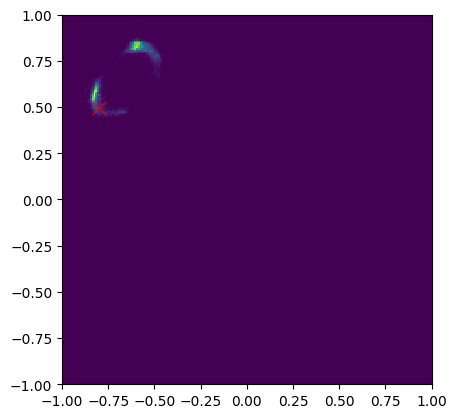

 90%|████████▉ | 8998/10000 [09:10<00:23, 42.82it/s, counter=0, loss=1.6247, ratio=0.9927, val_loss=1.6129]  

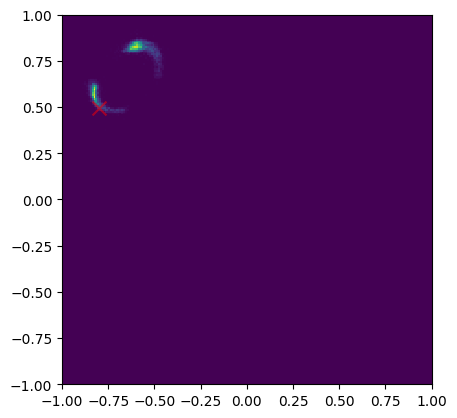

 30%|██▉       | 2996/10000 [01:34<03:24, 34.27it/s, counter=0, loss=1.6098, ratio=1.0051, val_loss=1.6181]

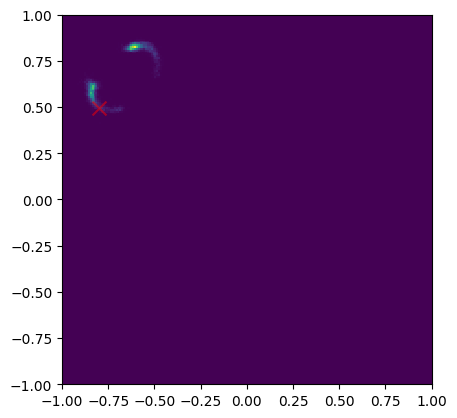

 60%|█████▉    | 5999/10000 [04:59<02:17, 29.09it/s, counter=0, loss=1.6103, ratio=0.9986, val_loss=1.6080]   

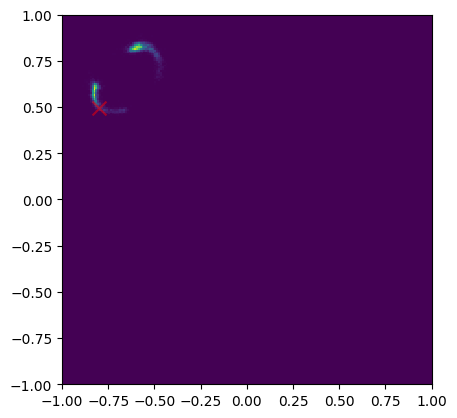

 82%|████████▎ | 8250/10000 [07:50<01:39, 17.55it/s, counter=0, loss=1.6111, ratio=1.0026, val_loss=1.6153]   


KeyboardInterrupt: 

In [36]:
if train_model:
    F_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(F_model)

                F_model = nnx.merge(graphdef, best_state)
                break

            loss = train_step(F_model, optimizer, rngs.train_step())
            l += loss.item()
            
            v_loss = val_loss(F_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                loss_ = l / 100
                val_ = v_l / 100

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(F_model)
                    counter = 0
                else:
                    counter += 1

                # scale = tree_get(optimizer.opt_state, "ReduceLROnPlateauState").scale.value
                # pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter, lr_scale=scale, val_loss = f"{val_:.4f}" )
                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

            if j>0 and j%3000 == 0:
                idx = 8
                F_cond = SimformerConditioner(F_model)
                F_wrapped = SimWrapper(F_cond)          
                samples, true_param, reference_samples = get_samples(F_wrapped, idx)
                plot_samples(samples, true_param)
        # print(l)

    F_model.eval()

In [ ]:
# # save the model
# if train_model:
#     checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
#         options=ocp.CheckpointManagerOptions(
#             max_to_keep=2,
#             keep_checkpoints_without_metrics=True,
#             create=True,
#         ),
#     )
#     model_state = nnx.state(F_model)
#     checkpoint_manager.save(
#         1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
#     )

#     checkpoint_manager.close()

In [ ]:
if train_model:
    plt.plot(loss_array, label="train loss")
    plt.plot(val_loss_array, label="val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

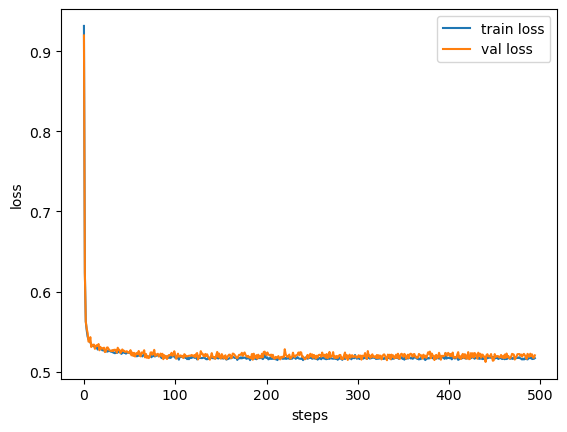

# sample the posterior

In [37]:
F_cond = SimformerConditioner(F_model)
F_wrapped = SimWrapper(F_cond)

AttributeError: 'Simformer' object has no attribute 'params'

In [ ]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx=8
observation = jnp.array(twomoons.get_observation(idx))
reference_samples = task.get_reference_posterior_samples(num_observation=idx)

In [ ]:
samples = get_samples(F_wrapped, idx, nsamples=100_000)[0]
# samples, true_param, reference_samples = get_samples(vf_wrapped, idx, nsamples=10)

In [ ]:
posterior_samples = samples

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=100, range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim((-1,1))
# plt.ylim((-1,1))
plt.show()

In [ ]:
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

In [ ]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# C2ST test

In [ ]:
from sbibm.metrics import c2st

In [ ]:
# convert posterior samples to a torch array
import torch
idx = 2
reference_samples = task.get_reference_posterior_samples(num_observation=idx)
posterior_samples = get_samples(vf_wrapped, idx, nsamples=reference_samples.shape[0])[0]
posterior_samples_torch = torch.tensor(np.array(posterior_samples), dtype=torch.float32)

In [ ]:
c2st_accuracy = c2st(reference_samples, posterior_samples_torch)

In [ ]:
c2st_accuracy